In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Information
1. **PassengerId:** id of passenger
2. **Survival:** 0 = No, 1 = Yes
3. **pclass:** (Ticket class) 
   * 1 = 1st, 2 = 2nd, 3 = 3rd
   * 1st = Upper / 2nd = Middle /3rd = Lower
4. **Name:** name of the passanger
5. **sex:** male/female
6. **Age:** Age in years (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
7. **sibsp:** # of siblings / spouses aboard the Titanic
   
   The dataset defines family relations in this way...
   * Sibling = brother, sister, stepbrother, stepsister
   * Spouse = husband, wife (mistresses and fiancés were ignored)
8. **parch:** # of parents / children aboard the Titanic
   
   The dataset defines family relations in this way...
   * Parent = mother, father
   * Child = daughter, son, stepdaughter, stepson
   * Some children travelled only with a nanny, therefore parch=0 for them.
9. **ticket:** Ticket number
10. **fare:** Passenger fare
11. **cabin:** Cabin number
12. **embarked:** Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


So, we have 2 featues filled with float values, 5 integer features, 5 object features.

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

we have null values in 3 featues(Age, Cabin, Embarked)

In [5]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We also have null values in the testing data set. So, we have to impute them.

In [6]:
# defining a function to check how much people are survived or non_survived
def get_value_counts(data):
    plt.figure(figsize = (15,5))
    plot = sns.countplot(hue = df["Survived"], x= df[data])
    return plot

<AxesSubplot:xlabel='Pclass', ylabel='count'>

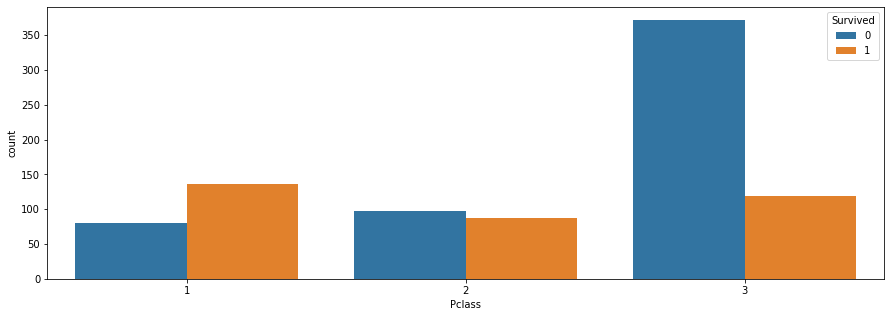

In [7]:
get_value_counts("Pclass")

Here we can see, in passanger class 1 more people are survived. In class 2 the passanger survived and non_survived nearly equal. But the highest non-survived passangers are in class 3. 

<AxesSubplot:xlabel='Sex', ylabel='count'>

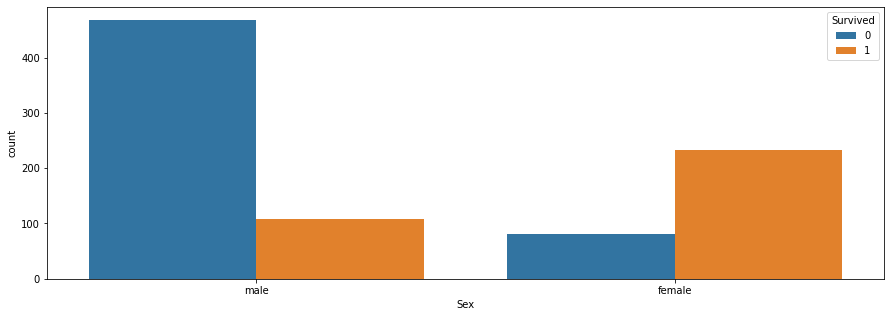

In [8]:
get_value_counts("Sex")

In this figure we can clearly see the death rate of male are much higher than female. Most of the female are survived. 

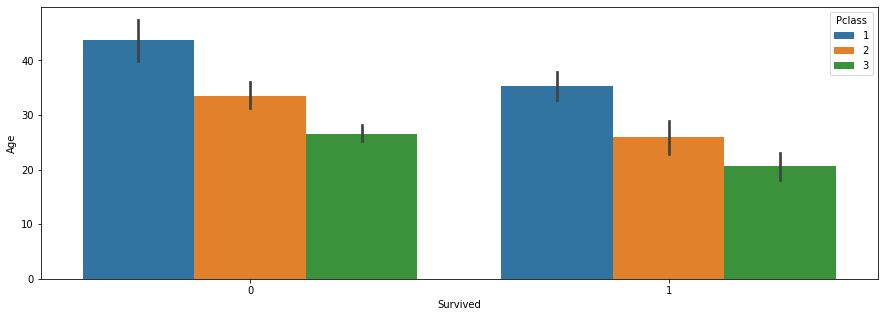

In [9]:
plt.figure(figsize = (15,5))
sns.barplot(df["Survived"],df["Age"],hue = df["Pclass"])
plt.show()

<AxesSubplot:xlabel='SibSp', ylabel='count'>

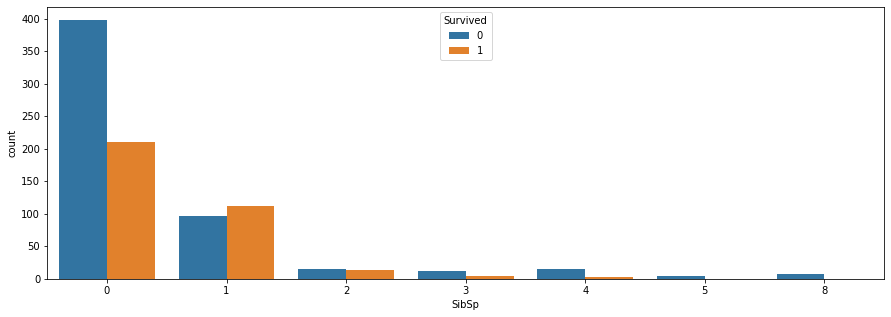

In [10]:
get_value_counts("SibSp")

people who are travelling alone are highest non_survival. and who has one sibling are survived more then non survived. 

<AxesSubplot:xlabel='Parch', ylabel='count'>

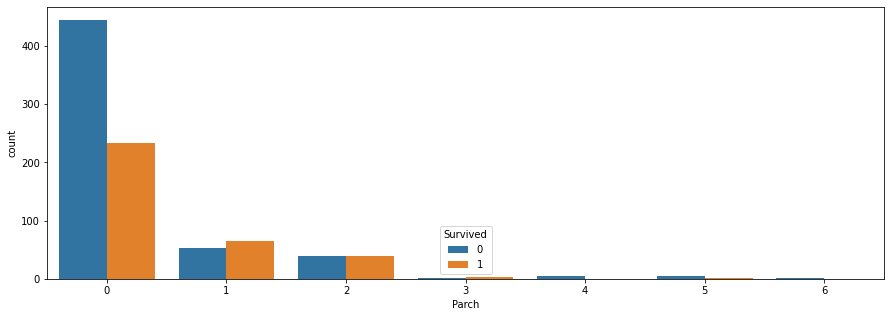

In [11]:
get_value_counts("Parch")

children who are traveling only with a nanny are the most non_suvived. 

<AxesSubplot:xlabel='Embarked', ylabel='count'>

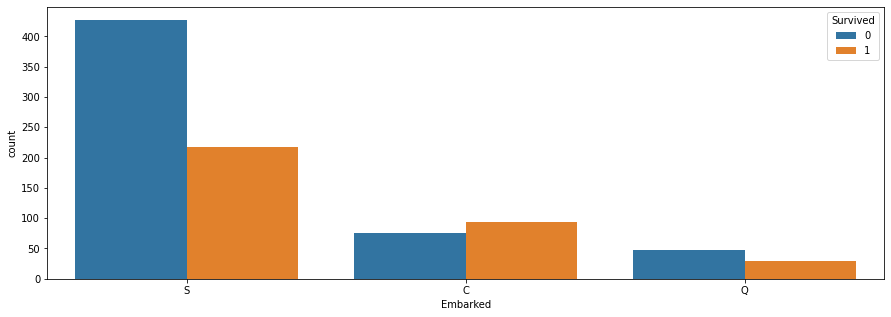

In [12]:
get_value_counts("Embarked")

Here we can see Port of Embarkation Cherbourg has higer survival rate. Queenstown, Southampton has high  non_survival rate.

<AxesSubplot:>

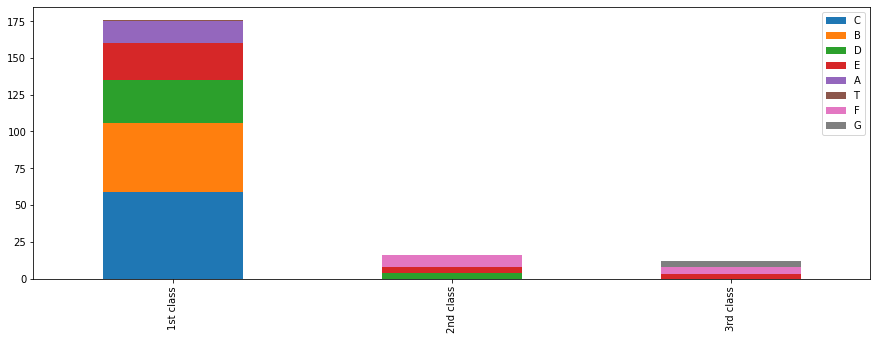

In [13]:
df1 = df
for i in (df1,):
    i["Cabin"] = i["Cabin"].str[0:1]
pcl1 = df1[df1["Pclass"]==1]["Cabin"].value_counts()
pcl2 = df1[df1["Pclass"]==2]["Cabin"].value_counts()
pcl3 = df1[df1["Pclass"]==3]["Cabin"].value_counts()
_temp = pd.DataFrame([pcl1,pcl2,pcl3],index = ["1st class","2nd class","3rd class"])
_temp.plot(kind="bar",stacked = True, figsize=(15,5))

Here we can see the most of the 1st class passangers are in A cabin then E cabin. And 2nd class passengers are in f cabin. G cabin have the 3rd class passsangers

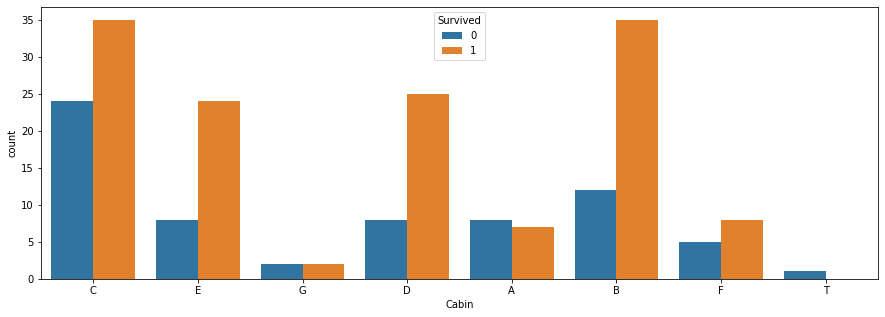

In [14]:
plt.figure(figsize = (15,5))
sns.countplot(df1["Cabin"], hue = df1["Survived"])
plt.show()

Here we can see the A cabin passangers are higest survived and B cabin passangers are the highest non_survived. 

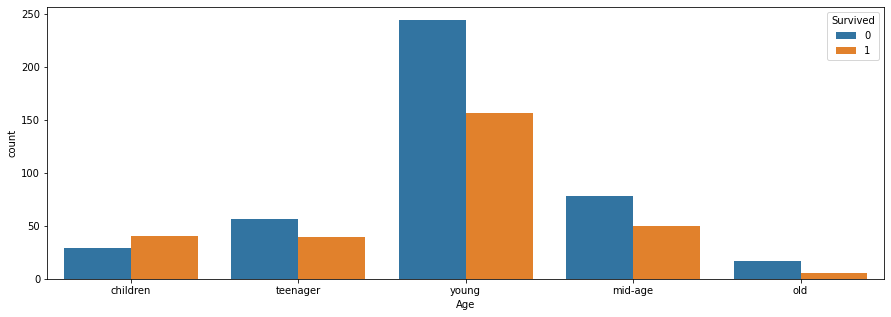

In [15]:
_temp = df.copy()
label = ["children","teenager","young","mid-age","old"]
bin1 = [0,12,19,40,60,90]
_temp["Age"] = pd.cut(x = _temp["Age"], bins = bin1, labels = label)
plt.figure(figsize = (15,5))
sns.countplot(_temp["Age"], hue = _temp["Survived"])
plt.show()

here we can see that children has high survived rate. Most of the passangers are in their young age and died. 

# Feature Engineering

In [16]:
df_te = df.copy()
df_tr = test_df.copy()

**first we will drop the irrelevant features.**
* passegerid has all unique values. 
* fare has no information regarding survived as we already has p class.
* name has no effect on survival 
* ticket is not taking part in defining survival
* cabin is also highly co rellated with p class

In [17]:
df.drop(["PassengerId", "Fare", "Name", "Ticket","Cabin",],axis = 1,inplace = True)
test_df.drop(["PassengerId", "Fare", "Name", "Ticket","Cabin",],axis = 1, inplace = True)
df.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S


**Changing Age Feature into Categorical Feature**

In [18]:
label = ["children","teenager","young","mid-age","old"]
bin1 = [0,12,19,40,60,90]
df["Age"] = pd.cut(x = df["Age"], bins = bin1, labels = label) # on training data
test_df["Age"] = pd.cut(x = test_df["Age"], bins = bin1, labels = label) # on testing data
test_df.head(1)

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,young,0,0,Q


**Handling the missing value**

**We will use mode for categorical featue**

In [19]:
df["Age"].fillna(mode(df["Age"])[0][0], inplace = True)
df["Embarked"].fillna(mode(df["Embarked"])[0][0], inplace = True)

# filling missing values in testing dataset
test_df["Age"].fillna(mode(test_df["Age"])[0][0], inplace = True)

**Encoding of the features**
* we will use replace function for ordinal data 
* we will use onhot encoder for nominal data

In [44]:
# using replace function for ordinal data
df.replace({"children":0,"teenager":1,"young":2,
            "mid-age":3,"old":4},inplace = True) # on training data
test_df.replace({"children":0,"teenager":1,
                 "young":2,"mid-age":3,"old":4},inplace = True) # on testing data
df["Age"] = df["Age"].astype(int) # making data in integer
test_df["Age"] = test_df["Age"].astype(int)

In [ ]:
# using one-hot encoder for nominal data
ohe = OneHotEncoder()
df[list(df["Sex"].unique())] = ohe.fit_transform(df[["Sex"]]).A
df[list(df["Embarked"].unique())] = ohe.fit_transform(df[["Embarked"]]).A
#using on testing data
test_df[list(test_df["Sex"].unique())] = ohe.fit_transform(test_df[["Sex"]]).A
test_df[list(test_df["Embarked"].unique())] = ohe.fit_transform(test_df[["Embarked"]]).A

In [ ]:
df.drop(["Sex","Embarked"],axis = 1, inplace = True)
test_df.drop(["Sex","Embarked"],axis = 1, inplace = True)

# Model Selection and Training 

In [49]:
x = df.drop("Survived",axis = 1)
y = df["Survived"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42,stratify=y)

In [50]:
lst = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("Decision Tree",DecisionTreeClassifier()),
       ("RandomForest",RandomForestClassifier()),
      ("AdaBoost",AdaBoostClassifier()),
      ("XGBoost",XGBClassifier())]
for name,model in lst:
    model.fit(x_train,y_train)
    y1 = model.predict(x_train)
    accuracy = accuracy_score(y_train,y1)
    y2 = model.predict(x_test)
    acc_te = accuracy_score(y_test,y2)
    print(f"For {name}::\nThe Training Accuracy is: {accuracy}\nThe Testing Accuracy is: {acc_te}")
    print("--"*40)

For LogisticRegression::
The Training Accuracy is: 0.8117977528089888
The Testing Accuracy is: 0.7877094972067039
--------------------------------------------------------------------------------
For KNN Classifier::
The Training Accuracy is: 0.8286516853932584
The Testing Accuracy is: 0.8156424581005587
--------------------------------------------------------------------------------
For Decision Tree::
The Training Accuracy is: 0.8721910112359551
The Testing Accuracy is: 0.7877094972067039
--------------------------------------------------------------------------------
For RandomForest::
The Training Accuracy is: 0.8721910112359551
The Testing Accuracy is: 0.7988826815642458
--------------------------------------------------------------------------------
For AdaBoost::
The Training Accuracy is: 0.8132022471910112
The Testing Accuracy is: 0.7932960893854749
--------------------------------------------------------------------------------
For XGBoost::
The Training Accuracy is: 0.87078651

As we can see the Random forest and The XGBoost has good accuracy. So, we will go with the XGBoost as it has auto pruning concept

**optimising the model by hyperparameter tuning**

In [51]:
estimator = XGBClassifier()
param_grid = {'n_estimators': [100, 150],
              'max_depth': [1, 2],
              'learning_rate': [0.1, 0.01],
              'min_child_weight': [3, 4],
              'subsample': [0.6, 0.7],
              'colsample_bytree': [0.2, 0.3]}
rscv = RandomizedSearchCV(estimator,param_grid,cv = 5)
rscv.fit(x_train,y_train)
rscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [52]:
rscv.best_params_

{'subsample': 0.6,
 'n_estimators': 150,
 'min_child_weight': 4,
 'max_depth': 2,
 'learning_rate': 0.1,
 'colsample_bytree': 0.3}

In [53]:
xgb = XGBClassifier(subsample = 0.6, n_estimators= 150,
                    min_child_weight = 4, max_depth= 2,
                    learning_rate= 0.1, colsample_bytree= 0.3)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [54]:
# checking the performance of the model at Training time
y_pr_train = xgb.predict(x_train)
acc_train = accuracy_score(y_train,y_pr_train)
class_re = classification_report(y_train,y_pr_train)
print("The accuracy of the model:",(acc_train)*100)
print("The classification report:\n",class_re)

The accuracy of the model: 83.00561797752809
The classification report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       439
           1       0.83      0.70      0.76       273

    accuracy                           0.83       712
   macro avg       0.83      0.80      0.81       712
weighted avg       0.83      0.83      0.83       712



In [55]:
# checking the performance of the model at Testing time
y_pr_test = xgb.predict(x_test)
acc_test = accuracy_score(y_test,y_pr_test)
class_re1 = classification_report(y_test,y_pr_test)
print("The accuracy of the model:",(acc_test)*100)
print("The classification report:\n",class_re1)

The accuracy of the model: 81.56424581005587
The classification report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.83      0.65      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



**exporting the prediction**

In [ ]:
# matching the column names with x_train
test_df = test_df[['Pclass', 'Age', 'SibSp', 'Parch', 'male', 'female', 'S', 'C', 'Q']]

In [59]:
final_prediction = xgb.predict(test_df)
final_df = pd.DataFrame({"PassengerId": df_tr["PassengerId"],"Survived": final_prediction})
final_df.to_csv("submission_shaumil.csv",index = False)

In [61]:
submitted = pd.read_csv("submission_shaumil.csv")
submitted.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
